In [3]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [16]:
pd.set_option('display.max_columns',None)

In [18]:
end_time = datetime.date.today()

In [19]:
start_time = end_time - datetime.timedelta(days=11850)

In [20]:
start_time

datetime.date(1990, 2, 13)

In [21]:
df = yf.download('^GSPC',start=start_time, end=end_time)

[*********************100%***********************]  1 of 1 completed


In [22]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-12,333.619995,333.619995,329.970001,330.079987,330.079987,118390000
1990-02-13,330.079987,331.609985,327.920013,331.019989,331.019989,144490000
1990-02-14,331.019989,333.200012,330.640015,332.010010,332.010010,138530000
1990-02-15,332.010010,335.209991,331.609985,334.890015,334.890015,174620000
1990-02-16,334.890015,335.640015,332.420013,332.720001,332.720001,166840000
...,...,...,...,...,...,...
2022-07-18,3883.790039,3902.439941,3818.629883,3830.850098,3830.850098,3414470000
2022-07-19,3860.729980,3939.810059,3860.729980,3936.689941,3936.689941,3160350000
2022-07-20,3935.320068,3974.129883,3922.030029,3959.899902,3959.899902,3452150000


In [23]:
df_replace = yf.download('^GSPC',start=start_time, end = end_time)

[*********************100%***********************]  1 of 1 completed


In [24]:
VIX = yf.download('^VIX',start=start_time, end=end_time)

[*********************100%***********************]  1 of 1 completed


In [30]:
df['daily return'] = df['Adj Close'].pct_change(1)

In [32]:
VIX.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [33]:
df['VIX'] = VIX['Adj Close']

In [34]:
df['relative_Volume'] = df['Volume'] / df['Volume'].rolling(40).mean()

In [37]:
df_anl = df[['daily return', 'VIX', 'relative_Volume']].copy()

In [38]:
df_anl

,daily return,VIX,relative_Volume
Date,,,
1990-02-12,NaN,24.379999,NaN
1990-02-13,0.002848,23.760000,NaN
1990-02-14,0.002991,22.049999,NaN
1990-02-15,0.008674,19.709999,NaN
1990-02-16,-0.006480,20.780001,NaN
...,...,...,...
2022-07-18,-0.008364,25.299999,0.888594
2022-07-19,0.027628,24.500000,0.828128
2022-07-20,0.005896,23.879999,0.909514


In [40]:
# remove NAN
df_anl = df_anl[40:]
df_replace = df_replace[40:]

In [42]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.7 MB/s eta 0:00:003.3 MB/s eta 0:00:01


---
### Start ML

In [43]:
from tqdm import tqdm

In [51]:
wcss = []

for i in tqdm(range(1,10)):
    kmeans = KMeans(i)
    kmeans.fit(df_anl)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
number_clusters =range(1,10)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 13.95it/s]


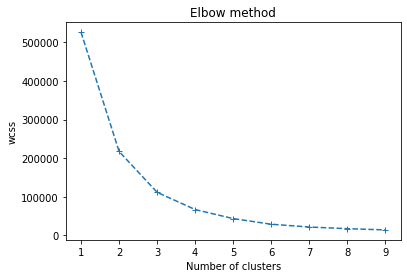

In [56]:
plt.plot(number_clusters,wcss,'+--')
plt.title('Elbow method')
plt.ylabel('wcss')
plt.xlabel('Number of clusters')
plt.show()

In [63]:
kmeans = KMeans(4)
df_anl['regime'] = kmeans.fit_predict(df_anl)
df_replace['regime'] = df_anl['regime']

/var/folders/jt/p6w8w24d0l584wmgx06v79740000gn/T/ipykernel_22730/2231542345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anl['regime'] = kmeans.fit_predict(df_anl)


Text(0.5, 1.0, 'cluster')

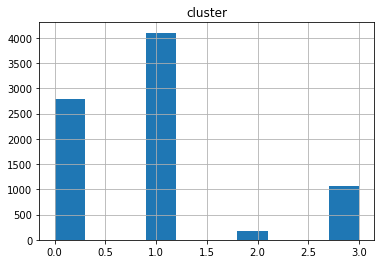

In [68]:
df_anl['regime'].hist()
plt.title("cluster")

---

### Visualize

In [70]:
col=[]
for i in range(0,len(df_replace)):
    if df_replace['regime'].iloc[i] ==0:
        col.append('blue')
    elif df_replace['regime'].iloc[i] ==1:
        col.append('red')
    elif df_replace['regime'].iloc[i] ==2:
        col.append('orange')
    else:
        col.append('brown')

In [149]:
col_df = pd.DataFrame({'date':df_replace.index,'color':col}).set_index('date')

In [150]:
def draw(start='1940',end='2022'):
    
    plot_df       = df_replace.loc[start:end].copy()
    color_plot_df = col_df[start:end].copy()
    plt.figure(figsize=(12,8))
    plt.scatter(plot_df.index, plot_df['Adj Close'], c=color_plot_df['color'],marker='.')

    plt.xlabel('years')
    plt.ylabel('Adj close')
    plt.grid('--',alpha=0.5)
    plt.show()

### 1. Full year

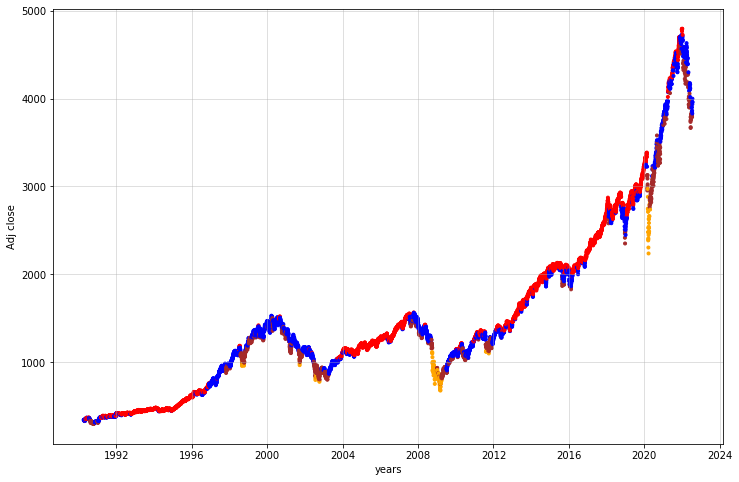

In [156]:
draw()

### 2. Covid19

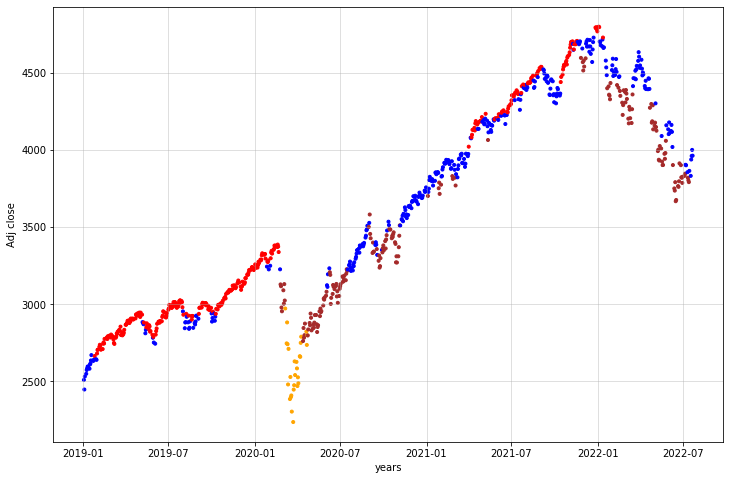

In [157]:
draw('2019','2022')

### 3. LEHMAN BROTHERS

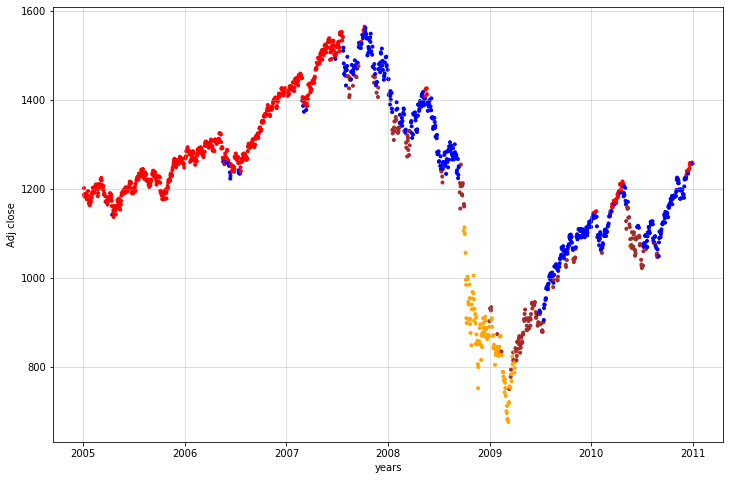

In [155]:
draw('2005','2010')